<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Interpretation" data-toc-modified-id="Interpretation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Interpretation</a></span></li><li><span><a href="#load-the-trained-model" data-toc-modified-id="load-the-trained-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>load the trained model</a></span></li><li><span><a href="#Prediction-using-TTA" data-toc-modified-id="Prediction-using-TTA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Prediction using TTA</a></span></li><li><span><a href="#Looking-at-the-results" data-toc-modified-id="Looking-at-the-results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Looking at the results</a></span></li></ul></div>

### Interpretation 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['food-101', '15-food-101-mixup', '12-food-101']


In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [3]:
path = Path("../input/food-101/food-101/food-101")
path.ls()

[PosixPath('../input/food-101/food-101/food-101/images'),
 PosixPath('../input/food-101/food-101/food-101/meta'),
 PosixPath('../input/food-101/food-101/food-101/.DS_Store'),
 PosixPath('../input/food-101/food-101/food-101/README.txt'),
 PosixPath('../input/food-101/food-101/food-101/license_agreement.txt')]

In [4]:
 path1 = Path("../input/15-food-101-mixup/Models")
path1.ls()

[PosixPath('../input/15-food-101-mixup/Models/history1.csv'),
 PosixPath('../input/15-food-101-mixup/Models/food-101-res50-224-nb-15-Mix.pth')]

In [5]:
train_df = pd.read_csv(path/'meta/train.txt', header=None)
test_df = pd.read_csv(path/'meta/test.txt', header=None)

train_df['valid']=0
test_df['valid']=1

train_df.columns = ['name', 'valid']
test_df.columns = ['name', 'valid']

train_df['label'] = train_df.name.apply(lambda o: Path(o).parts[0])
test_df['label'] = test_df.name.apply(lambda o: Path(o).parts[0])

df = train_df.append(test_df)
print(len(df))
df.head()

101000


name  valid      label
0  apple_pie/1005649      0  apple_pie
1  apple_pie/1014775      0  apple_pie
2  apple_pie/1026328      0  apple_pie
3  apple_pie/1028787      0  apple_pie
4  apple_pie/1043283      0  apple_pie

In [6]:
il = ImageList.from_df(df, path/'images', suffix=".jpg"); il

ImageList (101000 items)
Image (3, 512, 308),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: ../input/food-101/food-101/food-101/images

In [7]:
# il = il.use_partial_data(sample_pct=0.3)

In [8]:
s = il.split_from_df(col=1); s

ItemLists;

Train: ImageList (75750 items)
Image (3, 512, 308),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: ../input/food-101/food-101/food-101/images;

Valid: ImageList (25250 items)
Image (3, 512, 512),Image (3, 512, 384),Image (3, 512, 384),Image (3, 512, 382),Image (3, 342, 512)
Path: ../input/food-101/food-101/food-101/images;

Test: None

In [9]:
src = s.label_from_df(cols=2); src

LabelLists;

Train: LabelList (75750 items)
x: ImageList
Image (3, 512, 308),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: ../input/food-101/food-101/food-101/images;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 384),Image (3, 512, 384),Image (3, 512, 382),Image (3, 342, 512)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: ../input/food-101/food-101/food-101/images;

Test: None

In [10]:
xtra = [brightness(change=(0.40,0.63), p=0.75), contrast(scale=(0.95,1.1), p=0.75), crop(size=224, row_pct=(0.3,0.7), col_pct=(0.3,0.7)), 
        squish(scale=(0.80,1.2)), tilt(direction=(0,3), magnitude=(-0.3,0.3)), skew(direction=(0,3), magnitude=(-0.2,0.2))]
tfms = get_transforms(max_rotate=30., max_warp=0.3, max_lighting=None, p_affine=0.75, xtra_tfms= xtra)

In [11]:
data = (src.transform(tfms=tfms, size=224)
        .databunch(bs=32)
        .normalize(imagenet_stats))

In [12]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy, top_k_accuracy], pretrained=False, ps=0.5, wd=0.1,
                    model_dir = '/kaggle/working/Models')

### load the trained model

In [13]:
file = open('../input/../input/15-food-101-mixup/Models/food-101-res50-224-nb-15-Mix.pth', 'rb')
type(file)

_io.BufferedReader

In [14]:
learn.load(file=file);

In [15]:
file.close()
file.closed

True

In [16]:
learn.validate(learn.data.valid_dl)

[0.4892422, tensor(0.8700), tensor(0.9751)]

In [17]:
learn.validate(learn.data.train_dl)

[0.42016685, tensor(0.8939), tensor(0.9785)]

### Prediction using TTA

In [18]:
preds = learn.TTA()

In [19]:
accuracy(*preds), top_k_accuracy(*preds)

(tensor(0.8820), tensor(0.9790))

**We see an increase of accuracy using TTA from 86.3% Top-1 accuracy, 97.4% Top-5 accuracy to 88.2% Top-1 accuracy, 97.9% Top-5 accuracy**

### Looking at the results

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

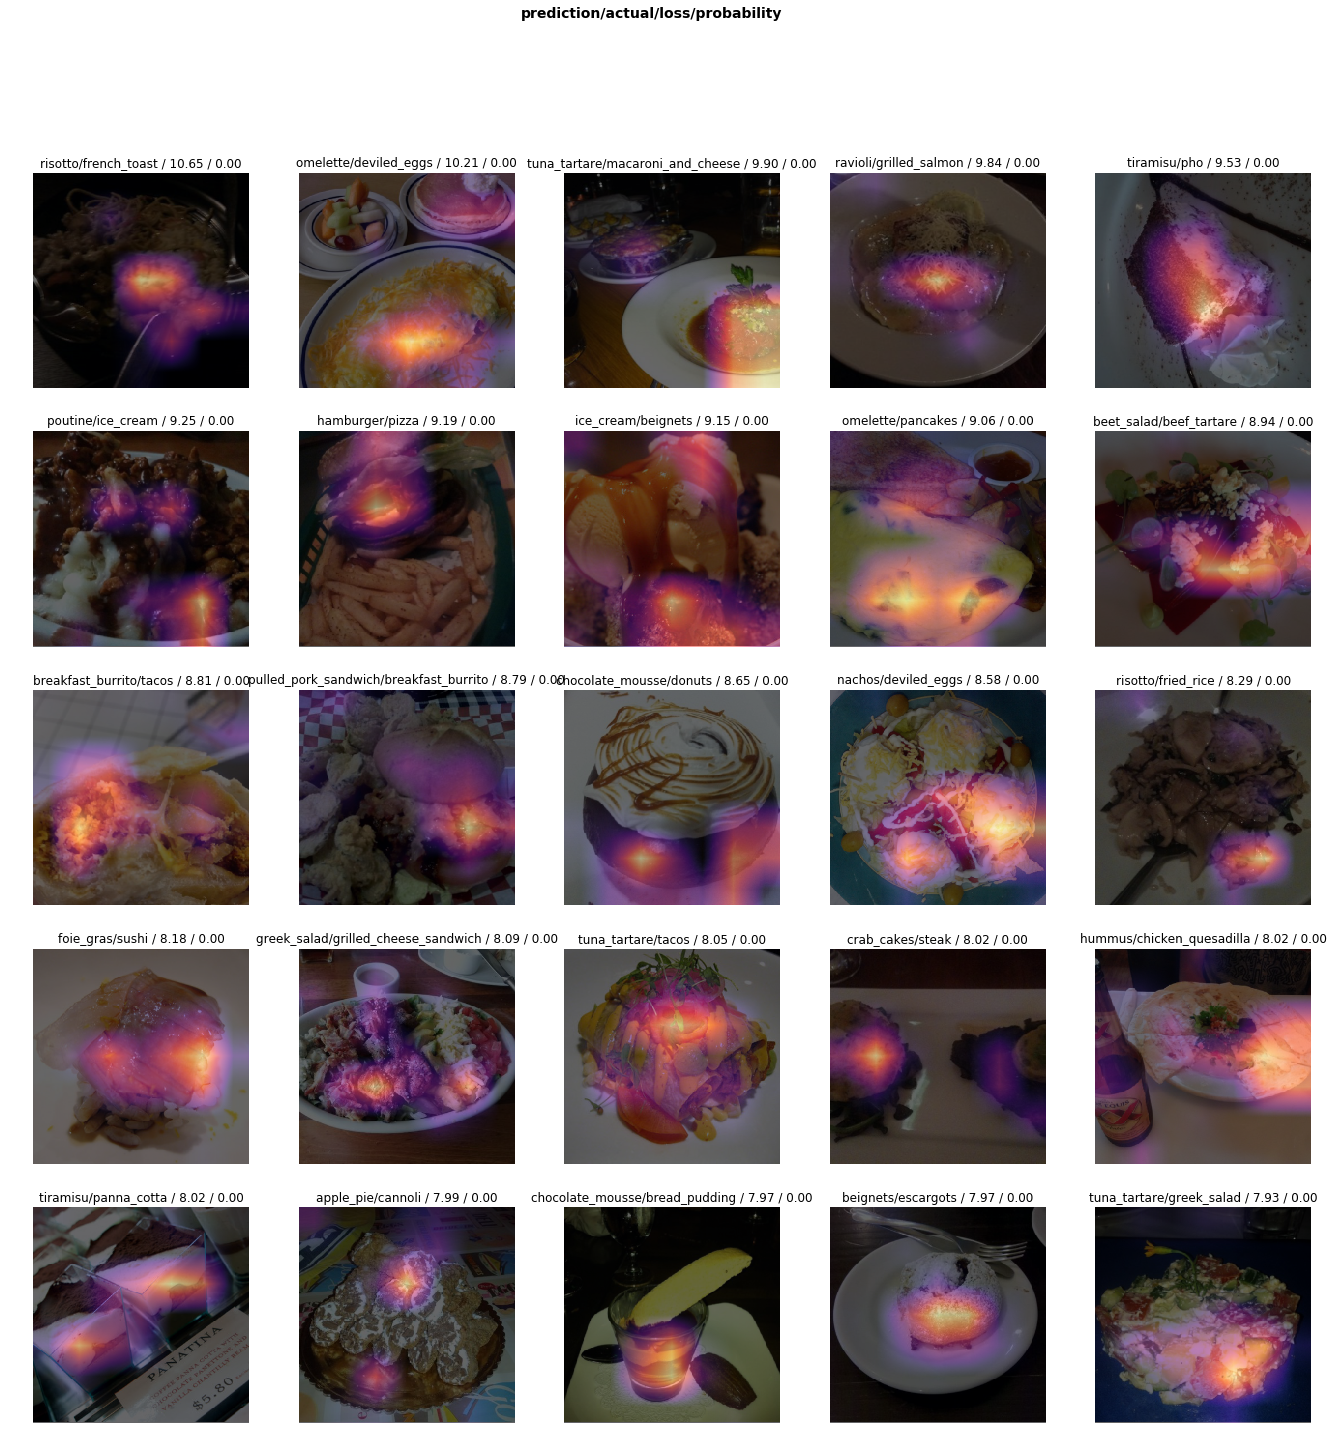

In [21]:
interp.plot_top_losses(k=25, figsize=(23,23))

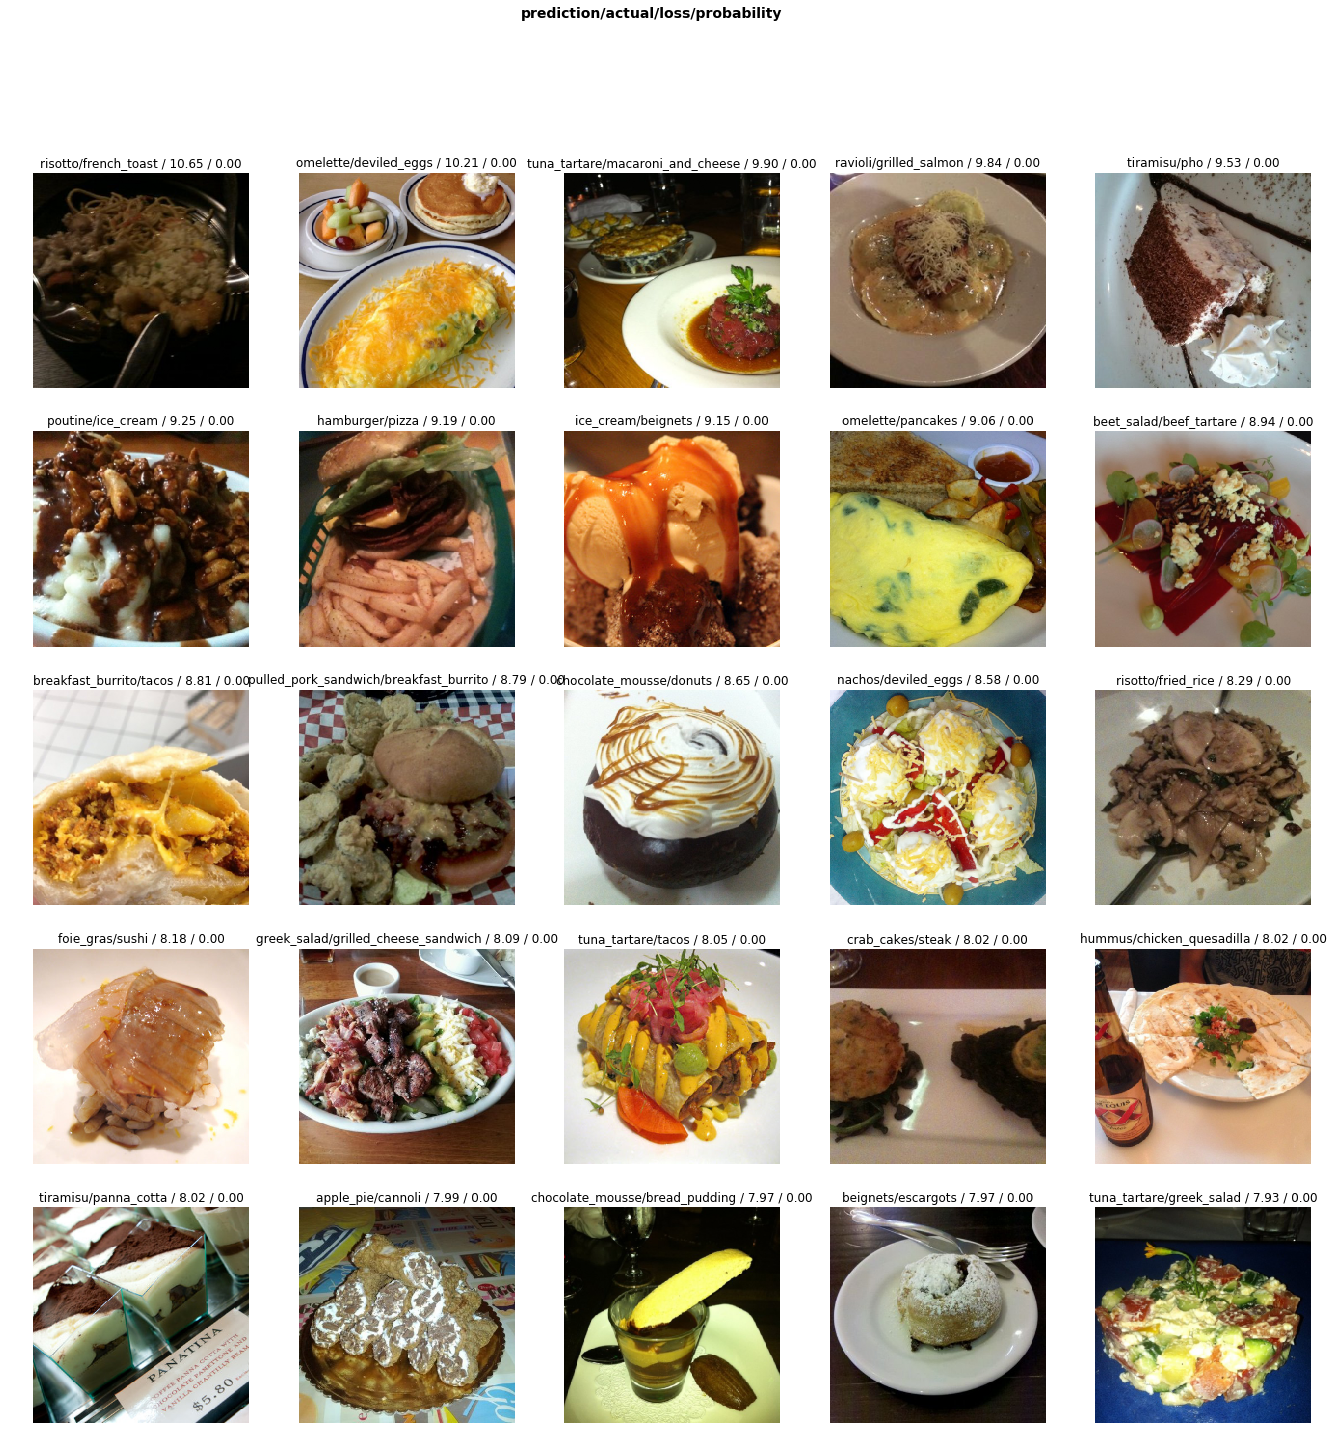

In [22]:
interp.plot_top_losses(k=25, figsize=(23,23), heatmap=False)

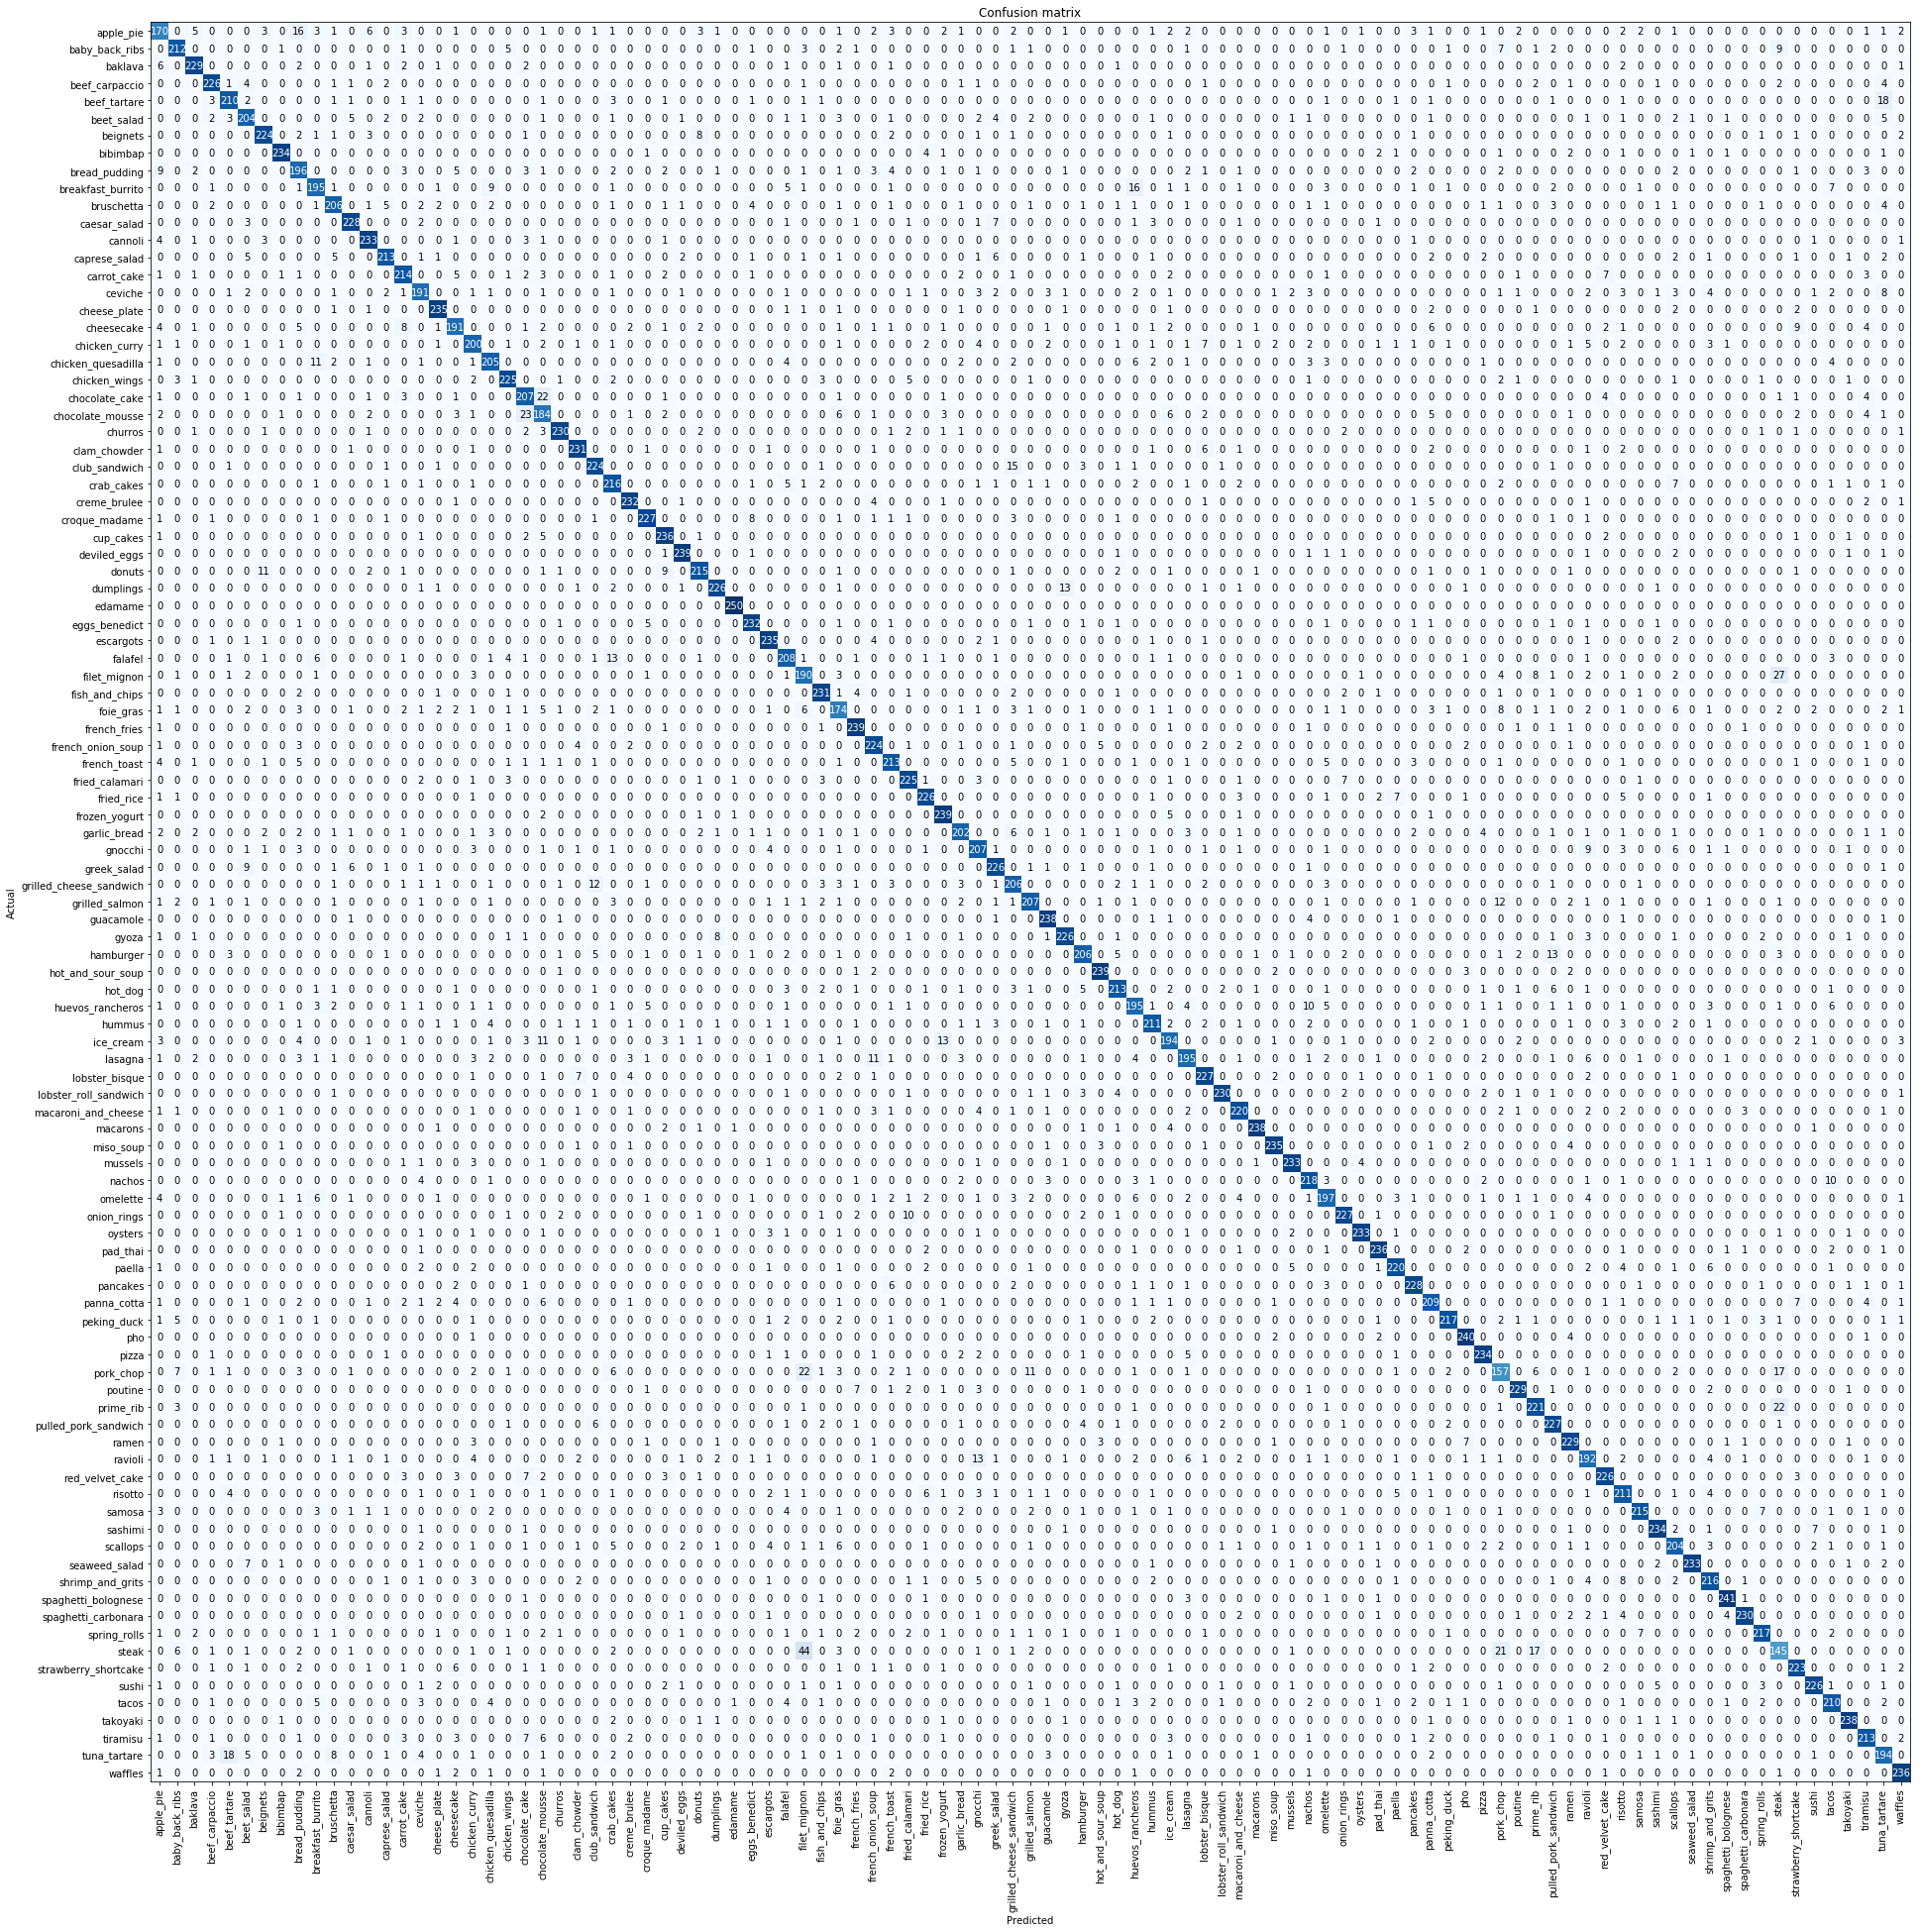

In [23]:
interp.plot_confusion_matrix(figsize=(27,27))

Check the most confusing classes

In [24]:
most_confused = interp.most_confused(min_val=12)

In [25]:
most_confused

[('steak', 'filet_mignon', 44),
 ('filet_mignon', 'steak', 27),
 ('chocolate_mousse', 'chocolate_cake', 23),
 ('chocolate_cake', 'chocolate_mousse', 22),
 ('pork_chop', 'filet_mignon', 22),
 ('prime_rib', 'steak', 22),
 ('steak', 'pork_chop', 21),
 ('beef_tartare', 'tuna_tartare', 18),
 ('tuna_tartare', 'beef_tartare', 18),
 ('pork_chop', 'steak', 17),
 ('steak', 'prime_rib', 17),
 ('apple_pie', 'bread_pudding', 16),
 ('breakfast_burrito', 'huevos_rancheros', 16),
 ('club_sandwich', 'grilled_cheese_sandwich', 15),
 ('dumplings', 'gyoza', 13),
 ('falafel', 'crab_cakes', 13),
 ('hamburger', 'pulled_pork_sandwich', 13),
 ('ice_cream', 'frozen_yogurt', 13),
 ('ravioli', 'gnocchi', 13),
 ('grilled_cheese_sandwich', 'club_sandwich', 12),
 ('grilled_salmon', 'pork_chop', 12)]

In [26]:
matrix = interp.confusion_matrix()

In [27]:
err_list = [matrix[i][i] for i in range(len(matrix))]

In [28]:
classes = data.valid_ds.y.classes

In [29]:
err_list = np.array(err_list)

In [30]:
order = err_list.argsort()

In [31]:
err_list[order]

array([145, 157, 170, 174, ..., 239, 240, 241, 250])

In [32]:
np.array(classes)[order]

array(['steak', 'pork_chop', 'apple_pie', 'foie_gras', ..., 'deviled_eggs', 'pho', 'spaghetti_bolognese', 'edamame'],
      dtype='<U23')